In [1]:
import sys
sys.path.append('/home/iaw/MYscrip/WatAna')
import os

In [2]:
from util.traj_xyz import *
from util.auto_corr_fft import *
from util.auto_corr_to_Iw import *
from util.read_qv import *

In [3]:
def save_Ct(fp: str, tau: NDArray, Ct: NDArray) -> None:
    with open(fp, "w+") as F:
        for i, i_x in enumerate(tau):
            F.writelines("{:.6f}, {:.6f}\n".format(i_x, Ct[i]))
            
def save_Ir(fp: str, title: str, freq, Iw_s: List) -> None:
    with open(fp, "w+") as F:
        F.writelines(title)
        for f, intensities in zip(freq, Iw_s):
            parts = ["{:.6f}".format(f)] + ["{:.6f}".format(i) for i in intensities]
            line = ", ".join(parts) + "\n"
            F.write(line)

In [4]:
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker

In [5]:
plt.rcParams["axes.labelweight"] ="bold" 
plt.rcParams["font.family"]="Times New Roman" 
plt.rcParams["font.weight"]="bold" 
plt.rcParams["font.size"]=14 
plt.rcParams["mathtext.default"]="regular"


def init_fig(ax):
    ax.spines['left'].set_position(('axes',0))
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    ax.tick_params(which='major'          # 设置对主刻度和次刻度生效
                        ,bottom=True           # 底部坐标轴
                        ,left=True             # 左侧坐标轴
                        , right = True
                        , top = True
                        ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                        ,width=2               # 设置刻度线粗细
                        ,length=8              # 设置长短
                        ,labelsize=20
    
                        )
    ax.tick_params(which='minor'          # 设置对主刻度和次刻度生效
                        ,bottom=True           # 底部坐标轴
                        ,left=True             # 左侧坐标轴
                        , right = True
                        , top = True
                        ,direction='in'       # 设置刻度线方向，'in' 表示朝内
                        ,width=2               # 设置刻度线粗细
                        ,length=5              # 设置长短
                        ,labelsize=20

                        )
    ax.xaxis.set_major_locator(ticker.MultipleLocator(500))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(250))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    return ax


# 加载数据

## 实验数据

In [6]:
exp_data = np.loadtxt("./data/exp_h2o.csv", delimiter=",")

## PBE的数据

### 45ps

In [13]:
pbe_mulliken_r_50ps = pbe_mulliken_r_config(
      dt = 0.0005   # ps
    , xyz_f= "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/50ps-pos.xyz"
    , mulliken_f = "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/mulliken/pbe_64_50ps_zjb_mulliken2.npy"
    , n_read = 100000 
    , qr_save = "./out/pbe_mulliken_50ps_qr3.npy"
)
pbe_mulliken_r_50ps_Ct_save = "./out/pbe_mulliken_r_50ps_Ct3.csv"
if not os.path.exists(pbe_mulliken_r_50ps.qr_save):
    u_d_50ps_pbe_mulliken = qr_pbe_mulliken2(pbe_mulliken_r_50ps)
else:
    u_d_50ps_pbe_mulliken = np.load(pbe_mulliken_r_50ps.qr_save)

# autocorr
Ct_50ps_pbe_mulliken_r = auto_corr_fft(u_d_50ps_pbe_mulliken, fraction_autocorrelation_function_to_fft = 0.1)
tau_50ps_pbe_mulliken_r = np.array(list(range(Ct_50ps_pbe_mulliken_r.shape[0])), dtype=np.float64) * pbe_mulliken_r_50ps.dt
# save
save_Ct(pbe_mulliken_r_50ps_Ct_save, tau_50ps_pbe_mulliken_r, Ct_50ps_pbe_mulliken_r)
# autocorr + hann
Ct_50ps_pbe_mulliken_r_hann = auto_corr_hann(Ct_50ps_pbe_mulliken_r)
# autocorr -> Ir
Iw_pbe_mulliken_r_50ps_hann = fft_to_Iw(tau_50ps_pbe_mulliken_r, Ct_50ps_pbe_mulliken_r_hann)
Iw_pbe_mulliken_r_50ps_wohann = fft_to_Iw(tau_50ps_pbe_mulliken_r, Ct_50ps_pbe_mulliken_r)

In [14]:
norm_func = lambda x: (x - x.min()) / (x.max() - x.min())

In [15]:
zjb_ir = np.loadtxt("/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/dipole/4/ir_spectrum_H2O_wannier.csv")

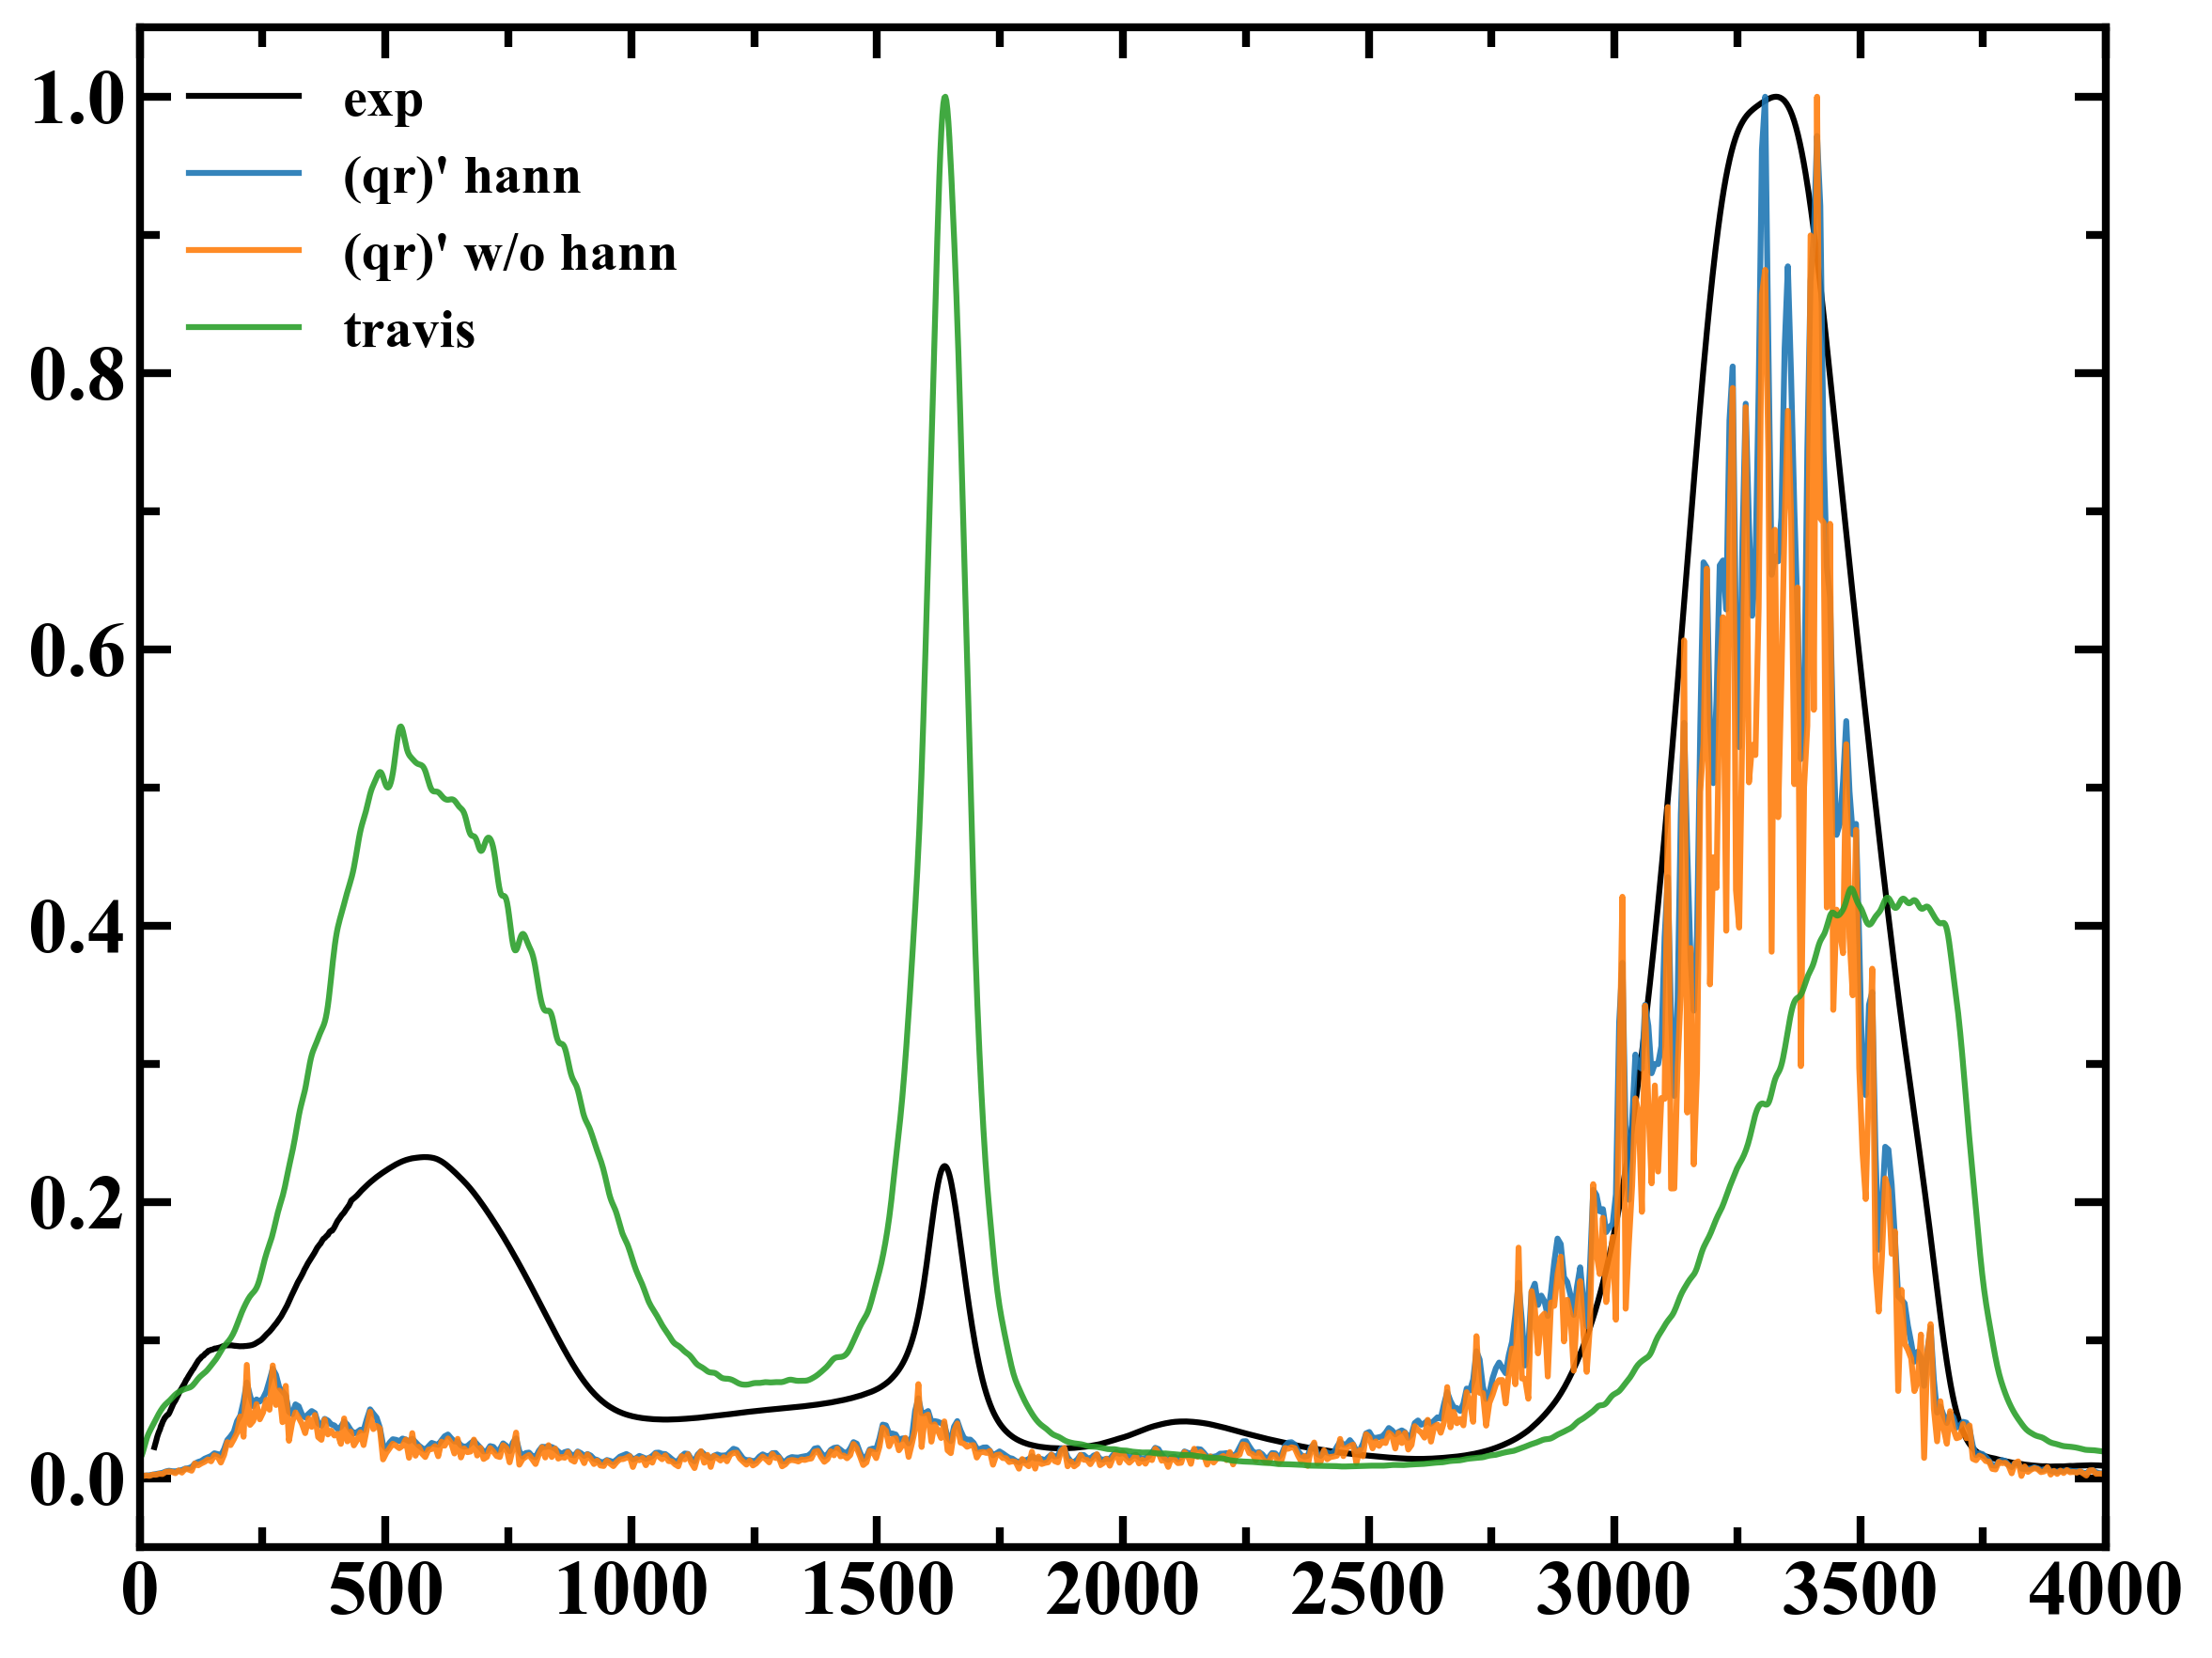

In [16]:
exp_data_y_norm = norm_func(exp_data[:, 1])
zjb_ir_norm = norm_func(zjb_ir[:, 1])
Iw_pbe_mulliken_r_50ps_hann_norm = norm_func(Iw_pbe_mulliken_r_50ps_hann[1])
Iw_pbe_mulliken_r_50ps_wohann_norm = norm_func(Iw_pbe_mulliken_r_50ps_wohann[1])

fig = plt.figure(figsize=(9,7),dpi=300)
ax1= plt.gca()
ax1 = init_fig(ax1)

ax1.plot(exp_data[:, 0], exp_data_y_norm, label = "exp", c = "black")
ax1.plot(Iw_pbe_mulliken_r_50ps_hann[0], Iw_pbe_mulliken_r_50ps_hann_norm, label = "(qr)' hann", alpha = 0.9)
ax1.plot(Iw_pbe_mulliken_r_50ps_wohann[0], Iw_pbe_mulliken_r_50ps_wohann_norm, label = "(qr)' w/o hann", alpha = 0.9)
ax1.plot(zjb_ir[:, 0], zjb_ir_norm, label = "travis", alpha = 0.9)

plt.xlim([0, 4000])
plt.legend(frameon=False, ncol=1)
plt.show()

In [ ]:
pbe_mulliken_r_50ps = pbe_mulliken_r_config(
      dt = 0.0005   # ps
    , xyz_f= "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/50ps-pos.xyz"
    , mulliken_f = "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/mulliken/pbe_64_50ps_zjb_mulliken2.npy"
    , n_read = 100000 
    , qr_save = "./out/pbe_mulliken_50ps_qr3.npy"
)


dt = 0.0005   # ps
n_read = 100000 
xyz_f = "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/50ps-pos.xyz"
vel_f = "/home/iaw/DATA/wat_md/bulk_pbe/64_zjb/raw-50ps/wat-MD-vel-1.xyz"

v1 = np.gradient(read_coor_from_xyz(xyz_f, n_read), dt, axis=0, edge_order = 2)
v2 = read_coor_from_xyz(vel_f, n_read)


In [22]:
np.linalg.norm(v1, axis=2).shape

(100000, 192)

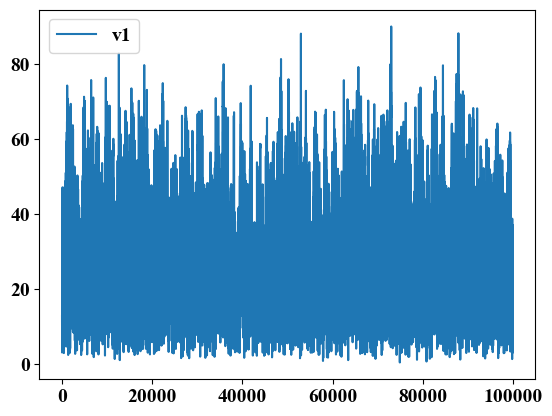

In [26]:
plt.plot(list(range(n_read)), np.linalg.norm(v1, axis=2)[:, 1], label = "v1")
#plt.plot(list(range(n_read)), np.linalg.norm(v2, axis=2)[:, 1], label = "v2")
plt.legend()

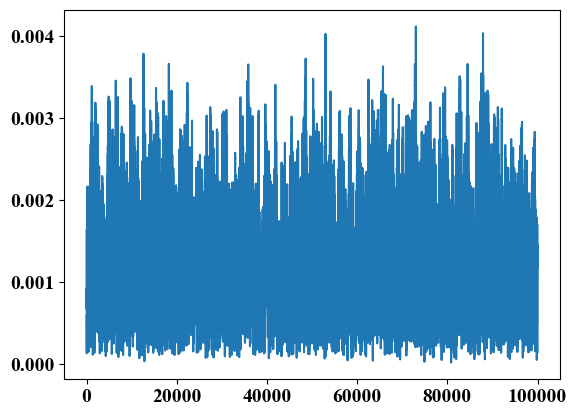

In [27]:
plt.plot(list(range(n_read)), np.linalg.norm(v2, axis=2)[:, 1], label = "v2")